In [103]:
# Cell for imports
import re
import os
import gzip
import time
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from stop_words import get_stop_words


In [104]:
#### Cell of all my function

def list_file_data(nom_directory):
    myListFile = []
    for f in os.listdir(nom_directory):
        if os.path.isdir(f): # si f est un dossier
            os.chdir(f) # On va lister son contenu
            parse()
            os.chdir('../') # On revient au répertoire précédent
        else:
            myListFile.append(f)
        # Traitement sur le fichier f
    return myListFile


def preprocesDataFile(fileName):
    input_file = gzip.open(fileName, 'rb')
    full_text = input_file.read()
    docListNum = re.findall('<doc><docno>(.*?)</docno>(.*?)</doc>', str(full_text).lower().strip())
    list_doc = re.findall('<doc><docno>(.*?)</docno>', str(full_text).strip())
    return docListNum, list_doc

def clean(text1,remove_w,stw ):
    full_text = text1.replace('\\n', '').strip(remove_w).replace("''",' ').replace("'",' ')
    full_text = [stemmer.stem(word) 
                 for word in full_text.split() 
                 if len(word)>1 
                 and word not in stw 
                 and not word.isnumeric()] ### remove stops_word and applique stemming
    #full_text = [word for word in full_text.split() if len(word)>1 and word not in stw and not word.isnumeric()] ### remove word and applique stemming
    return ' '.join(full_text)

def countWord(words):   
    word_count = {} # compte l'occurance d'un terme dans tous les documents
    j=0
    for word in words: # On parcours la listes de mots
        j+=1
        word  = word.lower()
        if (len(word)==1) or str(word).isnumeric():
            continue
        if not word in word_count:
            word_count[word] = 1
        else:
            word_count[word] = word_count[word] + 1
    return word_count

def countWordIntoDocs(dico, docno, posting):
    docname = docno
    
    for word, frequence in dico.items():
        posting.setdefault(word,[]).append((docname,frequence)) ### Remplace les lignes de commande suivante:
        """
        if not word in list(posting.keys()):
            posting[word] = [(docname, frequence)]
        else:
            posting[word].append((docname, frequence))
        """
    return posting

def document_lenght(list_terms,posting_list):
    dl = {}
    for doc, value in list_terms.items():
        somme_tf = 0
        for term in value:
            if term.isnumeric():
                continue
            for val in sorted(posting_list[term]):
                if val[0]==doc:
                    somme_tf+=val[1]
        dl[doc]=somme_tf
        return dl
    
def vocabulary_size(posting_list):
    return len(posting_list.keys())


def term_len(posting_list):
    return [(i, len(i)) for i in posting_list.keys()]

def collection_term_freq(posting_list):
    c_size={}
    for k,v in posting_list.items():
        somme=0
        for _,f in v: 
            somme+=f
        dl[k]=somme
        
## Pour avoir une courbe avec le plot
def plot_datas(data, title, label_x, label_y):
    x = list()
    y = list()
    for key, values in data.items():
        x.append(key)
        y.append(values[0])
    plt.plot(x,y, color='blue',marker='o',linestyle='solid')
    #Titre
    plt.title(title)
    # label
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.show()
    
## Fonction de traintement du texte  
def text_mining(fileName):
    start = time.time()
    docListNum, list_doc = preprocesDataFile(fileName)
    posting_list = {}
    for i in range(len(list_doc)):
        text_clean = clean(docListNum[i][1], list_char, stopwords)
        list_terms[list_doc[i]] = text_clean.split() # Here we create a dictionary of Here we create a dictionary of 
                                                                              # each docments with its terms
        lt = text_clean.split()
        current_dico = countWord(lt)
        posting_list = countWordIntoDocs(current_dico, list_doc[i], posting_list)

    file_number = fileName.split('/')[1].split('-',1)
    end = time.time()
    elapsed = end - start
    tf[file_number[0]] = term_len(posting_list)
    dl[file_number[0]] = document_lenght(list_terms,posting_list) 
    file_indexing_infos[file_number[0]]=(round(elapsed,3),tf[file_number[0]])
    
    return file_indexing_infos

In [105]:
### Cell to initialise variable.
directory = "Practice_02_data/"
list_data = list_file_data(directory)
list_data = sorted(list_data)
list_char = "_:/!?#^*~&()[]{}';$%|,.-"
posting_list = {}
posting_list_global = {}
file_indexing_infos = {}
dl = {}
tf = {}
stopwords = get_stop_words('english')
list_terms = {}
stemmer = PorterStemmer()

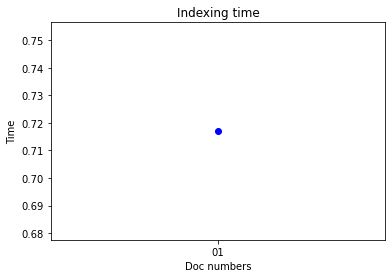

In [106]:
default_filename = str(directory+'01-Text_Only-Ascii-Coll-1-10-NoSem.gz')
datas = text_mining(default_filename)
plot_datas(datas, "Indexing time", "Doc numbers","Time")

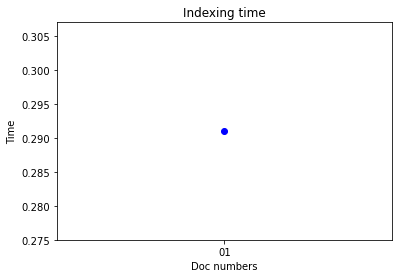

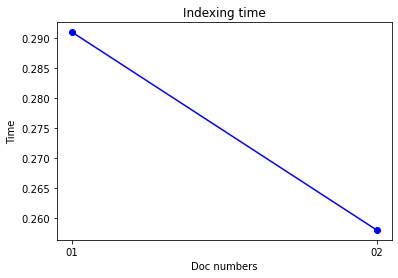

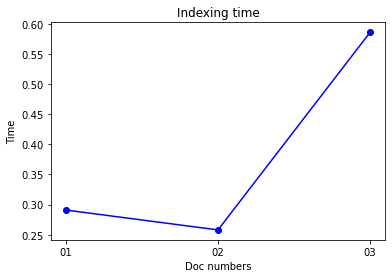

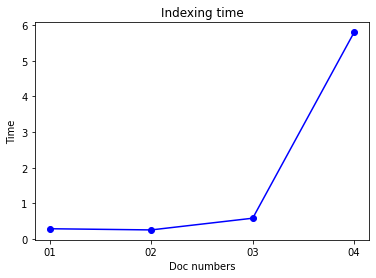

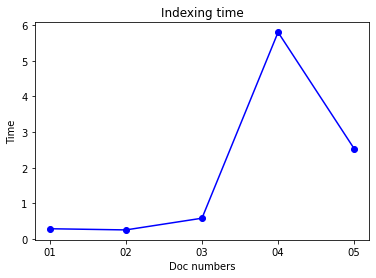

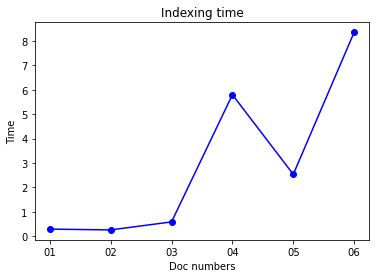

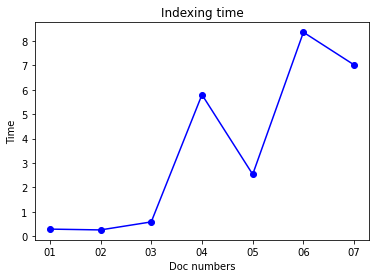

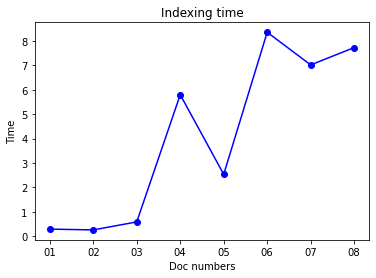

In [ ]:
#for a multiple collections
for index in range(len(list_data)):
    list_terms.clear()
    posting_list.clear()
    fileName = str(directory+list_data[index])
    datas = text_mining(fileName)
    plot_datas(datas, "Indexing time", "Doc numbers","Time")